In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import pickle
import networkx as nx
import ipywidgets

from run_simulation import invasion_main

In [2]:
simulation_df = invasion_main(10)
# print(type(simulation_df))
simulation_df

,County,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10
0,Cook,0.1,6.740523e-02,4.004359e-02,2.481478e-02,1.616770e-02,0.012981,0.009065,0.006577,0.004568,0.003202,0.002322
1,DuPage,0.0,1.375402e-02,2.549171e-02,2.262087e-02,1.580653e-02,0.013103,0.008424,0.005875,0.004167,0.003078,0.002149
2,Kane,0.3,1.524735e-01,8.080205e-02,4.403385e-02,2.569286e-02,0.015972,0.009843,0.006799,0.004541,0.003054,0.002129
3,Will,0.0,1.176618e-02,1.365198e-02,1.287766e-02,1.024304e-02,0.007966,0.005519,0.003778,0.002862,0.002116,0.001672
4,Winnebago,0.0,4.336471e-02,4.454348e-02,4.067078e-02,3.112686e-02,0.022466,0.017056,0.012030,0.007845,0.005111,0.003629
...,...,...,...,...,...,...,...,...,...,...,...,...
97,Henderson,0.0,5.200000e-06,9.800000e-06,2.149000e-05,2.918000e-05,0.000030,0.000041,0.000046,0.000044,0.000041,0.000037
98,Calhoun,0.0,2.343370e-03,3.597260e-03,3.141540e-03,3.224870e-03,0.002301,0.001807,0.001402,0.000943,0.000729,0.000499
99,Schuyler,0.0,2.000000e-07,6.440000e-06,1.666000e-05,3.242000e-05,0.000044,0.000050,0.000061,0.000057,0.000053,0.000048
100,Gallatin,0.0,1.000000e-07,5.800000e-07,1.770000e-06,2.600000e-06,0.000004,0.000007,0.000007,0.000007,0.000008,0.000008


In [3]:
visual_df = simulation_df.T
visual_df.columns = visual_df.iloc[0]
visual_df = visual_df.drop(visual_df.index[0])
visual_df

County,Cook,DuPage,Kane,Will,Winnebago,Lake,McHenry,St. Clair,Kendall,Madison,...,Scott,Stark,Jasper,Hamilton,Pike,Henderson,Calhoun,Schuyler,Gallatin,Pope
Week 0,0.1,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Week 1,0.067405,0.013754,0.152474,0.011766,0.043365,0.007375,0.006699,0.026136,0.00785,0.251076,...,0.00014,0.000052,0.000002,0.000001,0.000038,0.000005,0.002343,0.0,0.0,0.0
Week 2,0.040044,0.025492,0.080802,0.013652,0.044543,0.008956,0.014832,0.02315,0.011854,0.128733,...,0.000297,0.000212,0.000071,0.000007,0.000258,0.00001,0.003597,0.000006,0.000001,0.0
Week 3,0.024815,0.022621,0.044034,0.012878,0.040671,0.010025,0.012073,0.017438,0.011857,0.068396,...,0.0005,0.000291,0.000164,0.000018,0.000368,0.000021,0.003142,0.000017,0.000002,0.0
Week 4,0.016168,0.015807,0.025693,0.010243,0.031127,0.007991,0.011781,0.012401,0.009055,0.036516,...,0.000563,0.000347,0.000195,0.000029,0.000536,0.000029,0.003225,0.000032,0.000003,0.0
Week 5,0.012981,0.013103,0.015972,0.007966,0.022466,0.007151,0.00931,0.00872,0.007641,0.020186,...,0.000593,0.000387,0.000282,0.000025,0.000496,0.00003,0.002301,0.000044,0.000004,0.000001
Week 6,0.009065,0.008424,0.009843,0.005519,0.017056,0.006083,0.00686,0.005468,0.006081,0.011496,...,0.000532,0.000354,0.000245,0.000034,0.000419,0.000041,0.001807,0.00005,0.000007,0.000002
Week 7,0.006577,0.005875,0.006799,0.003778,0.01203,0.004984,0.00476,0.003967,0.004424,0.006815,...,0.000446,0.000376,0.000213,0.000033,0.000364,0.000046,0.001402,0.000061,0.000007,0.000002
Week 8,0.004568,0.004167,0.004541,0.002862,0.007845,0.003163,0.003719,0.002727,0.00323,0.004031,...,0.000368,0.000294,0.000239,0.000036,0.000359,0.000044,0.000943,0.000057,0.000007,0.000002
Week 9,0.003202,0.003078,0.003054,0.002116,0.005111,0.002923,0.002845,0.001941,0.002249,0.002614,...,0.000283,0.000221,0.000209,0.000038,0.000295,0.000041,0.000729,0.000053,0.000008,0.000004


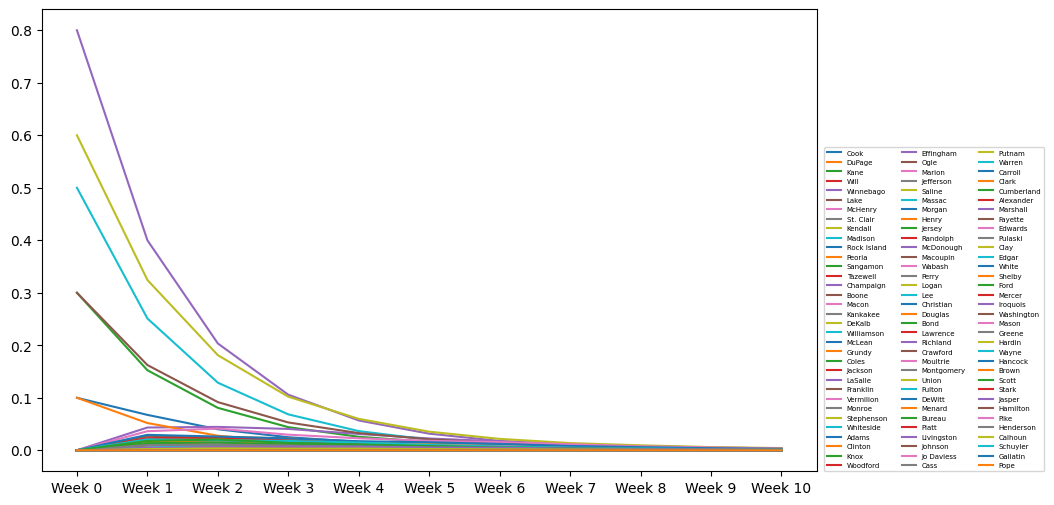

In [4]:
plt.figure(figsize=(10,6))
for county in visual_df.columns:
    plt.plot(visual_df.index, visual_df[county])
plt.legend(visual_df.columns, loc=(1.01, 0), fontsize=5, ncol=3)
plt.show()

In [5]:
path = 'data/location'
edges = pd.read_csv(f'{path}/county_edges.csv')

CG = pickle.load(open(f'{path}/IL_graph.dat', 'rb'))
handler = pickle.load(open(f'{path}/graph_handler_counties.dat', 'rb'))
highways = pickle.load(open(f'{path}/osmnx_highways.dat', 'rb'))

In [6]:
def make_network_heat(week):
    week = f'Week {week}'
    min_value = simulation_df[week].min()
#     max_value = simulation_df[week].max()  # This makes the scale variable for each chart
    max_value = 1  # This keeps the scale constant 
    cmap = matplotlib.colormaps['YlOrRd']

    node_colors = {}
    for node in CG.nodes():
        value = simulation_df.loc[simulation_df['County'] == node.name, week].iloc[0]
        normalized_value = (value - min_value) / (max_value - min_value)
        node_colors[node.name] = cmap(normalized_value)

    labels = {node: handler[node.name].name for node in CG.nodes()}
    fig, ax = plt.subplots(figsize=(10, 15))
    node_positions = {node: [node.centroid.x, node.centroid.y] for node in CG.nodes()}
    nx.draw(CG, 
            pos=node_positions,
            ax=ax, 
            node_color=[node_colors.get(node.name, 'gray') for node in CG.nodes()],
            node_size=1500, )

    nx.draw_networkx_labels(CG, 
                            pos=node_positions, 
                            labels=labels,
                            font_size=6, 
                            ax=ax,
                           font_color='k')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_value, vmax=max_value))
    sm.set_array([])
    sub_ax = plt.axes([0.96, 0.55, 0.02, 0.3])
    plt.colorbar(sm, cax=sub_ax)
    plt.show

In [9]:
@ipywidgets.interact(week = range(0, len(simulation_df.columns)-1))
def print_name(week):
    make_network_heat(week)

interactive(children=(Dropdown(description='week', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=0), Outpu…

In [ ]:
print(week.value)